# Goal

The goal here is to write everything with modular code and then conduct experiments that allow us to get ECN networks to work properly on the CityScapes dataset. We will try a few different approaches to improve results:

* Try different architectures, including a two-stage approach, as well as trying to predict residuals rather than the original $y$ labels
* Increasing the receptive field size on the input as well as the output


# Setup

In [9]:
import os
import matplotlib.pyplot as plt
import argparse
import numpy as np

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Embedding, LSTM, Dense, Conv2D, Flatten, Reshape, Add, Concatenate, MaxPool2D
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam
from keras import backend as K

from model.unet import unet, unet_small, dice_coef
from model.fcn import fcn_8s
from model.pspnet import pspnet50
from dataset_parser import generator_coarse, generator

from scripts import *

%load_ext autoreload
%autoreload 2

print('GPUs available:', K.tensorflow_backend._get_available_gpus())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
GPUs available: ['/job:localhost/replica:0/task:0/device:GPU:0']


# Train a Model on Coarse Data

In [16]:
TRAIN_BATCH = int(4)
VAL_BATCH = int(4)
lr_init = 1e-4
lr_decay = 5e-4
vgg_path = None
TRAIN_N = 2975
VAL_N = 500

model_name = "modular_unet_clean_benchmark.h5"

labels = ['background', 'car', 'road']  # Use only 3 classes.
ignore_pedestrians=not('person' in labels)

coarse_model = unet(input_shape=(256, 512, 3), num_classes=len(labels),
                    lr_init=lr_init, lr_decay=lr_decay, vgg_weight_path=vgg_path)

In [17]:
checkpoint = ModelCheckpoint(filepath=model_name,
                             monitor='val_dice_coef',
                             save_best_only=True,
                             save_weights_only=True)

In [18]:
history = coarse_model.fit_generator(generator.data_generator('dataset_parser/data.h5', TRAIN_BATCH, 'train', ignore_pedestrians=ignore_pedestrians),
                                     steps_per_epoch= TRAIN_N // TRAIN_BATCH,
                                     validation_data=generator.data_generator('dataset_parser/data.h5', VAL_BATCH, 'val', ignore_pedestrians=ignore_pedestrians),
                                     validation_steps= VAL_N // VAL_BATCH,
                                     callbacks=[checkpoint],
                                     epochs=5, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
500
500
2975
2975


743/743 [==============================] - 255s 343ms/step - loss: 0.2884 - dice_coef: 0.8304 - val_loss: 0.3791 - val_dice_coef: 0.8057
Epoch 2/5
743/743 [==============================] - 242s 325ms/step - loss: 0.1900 - dice_coef: 0.8921 - val_loss: 0.2412 - val_dice_coef: 0.8837
Epoch 3/5
743/743 [==============================] - 242s 325ms/step - loss: 0.1645 - dice_coef: 0.9081 - val_loss: 0.2880 - val_dice_coef: 0.8600
Epoch 4/5
743/743 [==============================] - 242s 326ms/step - loss: 0.1479 - dice_coef: 0.9174 - val_loss: 0.2046 - val_dice_coef: 0.8992
Epoch 5/5
743/743 [==============================] - 242s 326ms/step - loss: 0.1341 - dice_coef: 0.9255 - val_loss: 0.2058 - val_dice_coef: 0.8963


# View Predictions

Manually view them to confirm that the predictions on the training set are similar to the training labels

2975
2975
2975


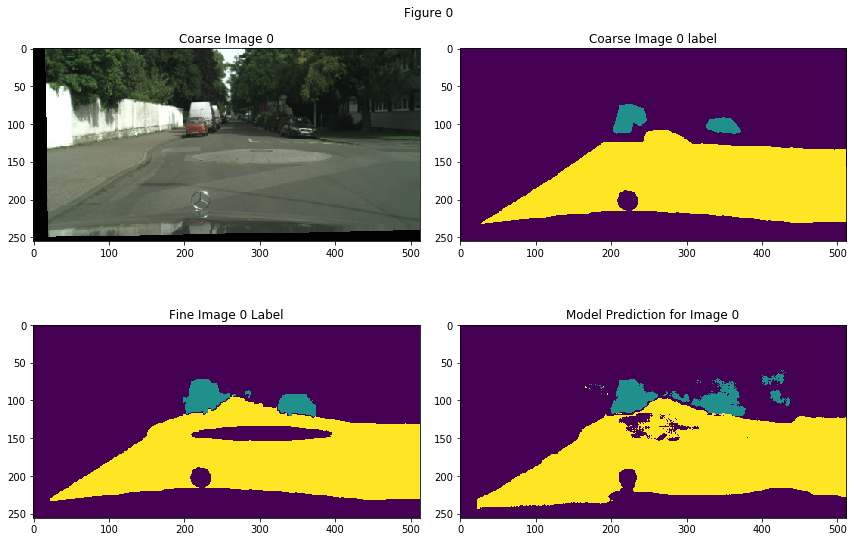

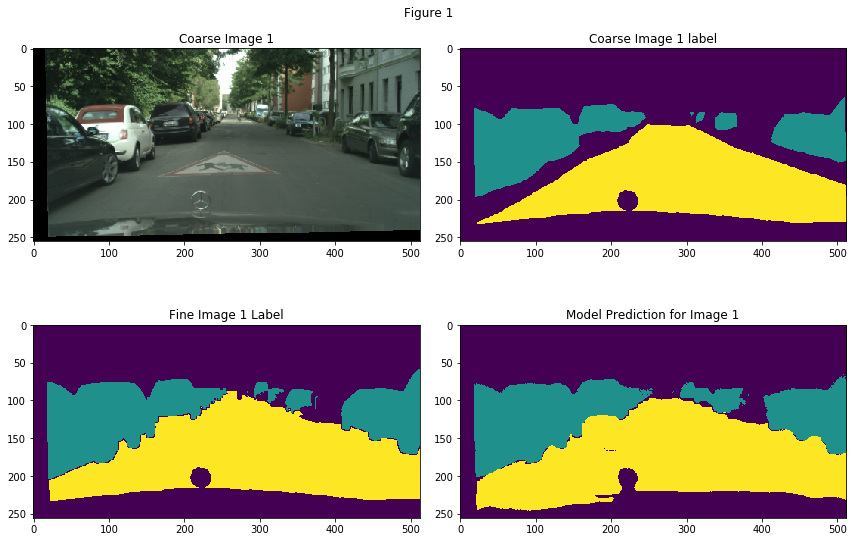

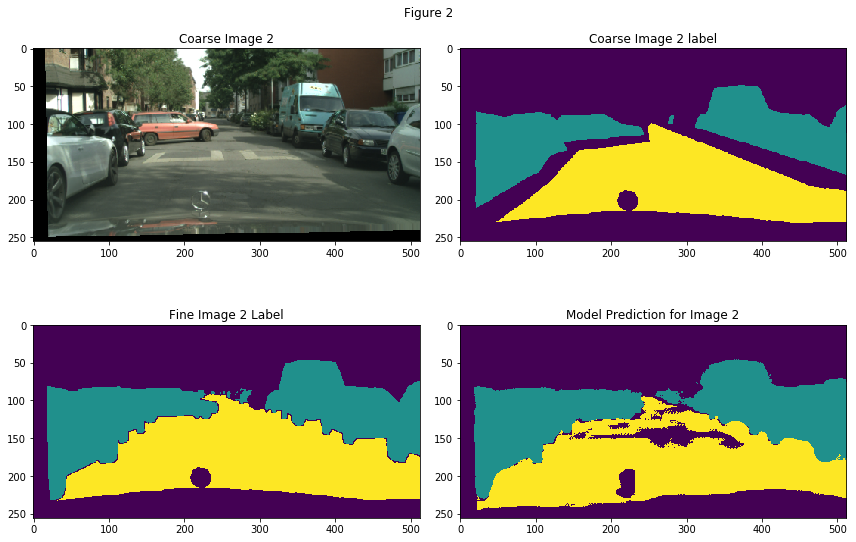

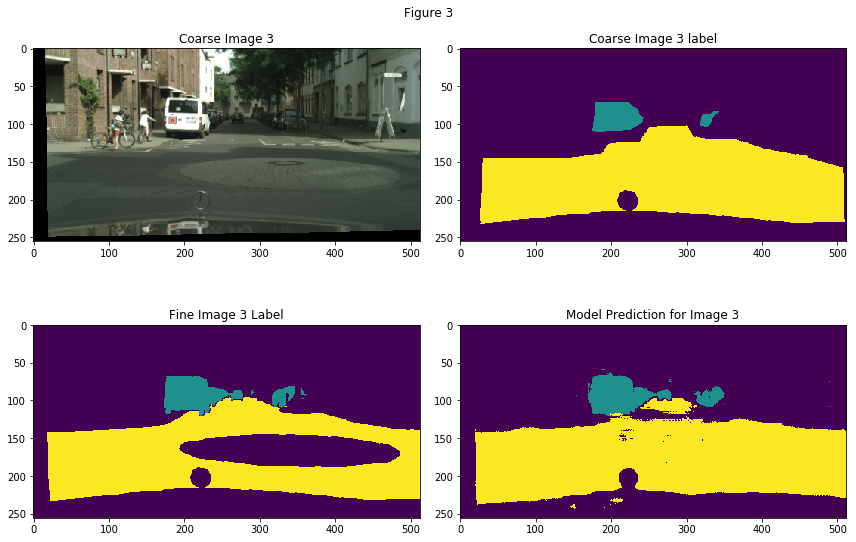

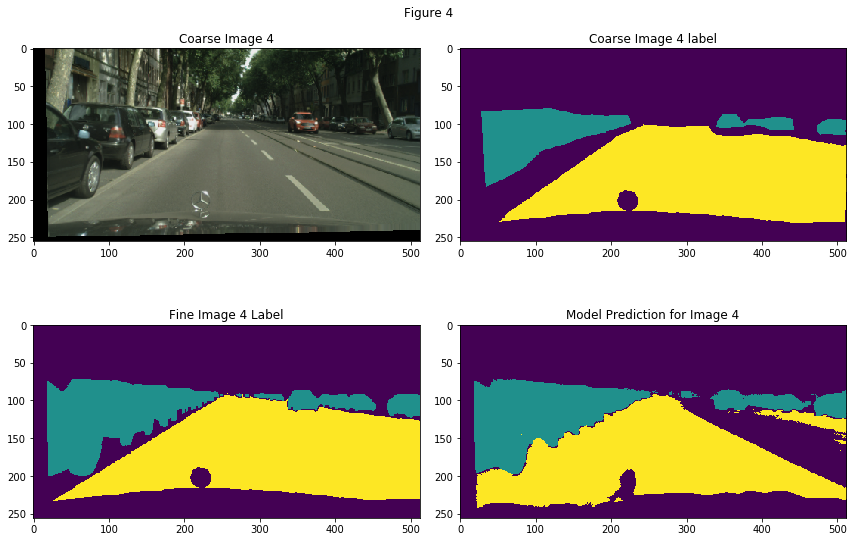

In [19]:
# coarse_model.load_weights("unet_coarse_model_weight.h5")
view_paired_predictions_on_training_data(coarse_model, ignore_pedestrians=ignore_pedestrians)

Manually view them to confirm that the predictions on the validation dataset are qualitatively similar to "coarse" labels